In [152]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pycbc.waveform


import chirpy.prob_phenom_model.ppm_utils

In [153]:
ROOT_DIR_MODEL_FILES = "/Users/sebastian.khan/personal/git/stk/chirpy/data"

In [154]:
ppm = chirpy.prob_phenom_model.ppm_utils.PPM(
    inspiral_freq_model_components_filename=os.path.join(ROOT_DIR_MODEL_FILES, 'freq_inspiral_11_09_23/components.cpkl'),
    merger_freq_model_components_filename=os.path.join(ROOT_DIR_MODEL_FILES, 'freq_merger_11_09_23/components.cpkl'),
    ringdown_freq_model_components_filename=os.path.join(ROOT_DIR_MODEL_FILES, 'freq_ringdown_11_09_23/components.cpkl'),
    inspiral_amp_model_components_filename=os.path.join(ROOT_DIR_MODEL_FILES, 'amp_inspiral_11_09_23/components.cpkl'),
    merger_amp_model_components_filename=os.path.join(ROOT_DIR_MODEL_FILES, 'amp_merger_11_09_23/components.cpkl'),
    ringdown_amp_model_components_filename=os.path.join(ROOT_DIR_MODEL_FILES, 'amp_ringdown_11_09_23/components.cpkl'),
    
)

In [155]:
# generate example waveform: set parameters here

# note that the model was trained on waveforms from approximate -800 M to 100 M (where t=0M is the peak amplitude.
# however, because the model as a PN inspiral you can evalute the model at earlier times however, the model has not been tested there.
# It does produce reasonable looking waveforms though.

q = 9 # mass-ratio defined as primary_mass / secondary_mass
Mtotal = 100 # total mass in Msun to evaluate the model at

t_start_M = -800
# t_start_M = -8000
t_end_M = 100
dt_M = 0.1

times_ = np.arange(t_start_M, t_end_M, dt_M) # time grid underlying the model. This is in geometric units (M)

delta_t = 1/4096 # sample rate in seconds for the returned time grid


# generate the best-fit model prediction (the GPR mean)
# retunrs a list of length 1 of pycbc TimeSeries
hp_ppm_bar, hc_ppm_bar = ppm.generate_pycbc_hp_hc(
    q=q,
    times=times_,
    M=Mtotal,
    delta_t=delta_t,
    n_samples=-1,
)

# generate samples from the model (sample the GP)
# returns a list of pycbc TimeSeries
hp_ppm_samples, hc_ppm_samples = ppm.generate_pycbc_hp_hc(
    q=q,
    times=times_,
    M=Mtotal,
    delta_t=delta_t,
    n_samples=50,
)

# these return pycbc TimeSeries objects.

Text(0.5, 1.0, 'mean waveform')

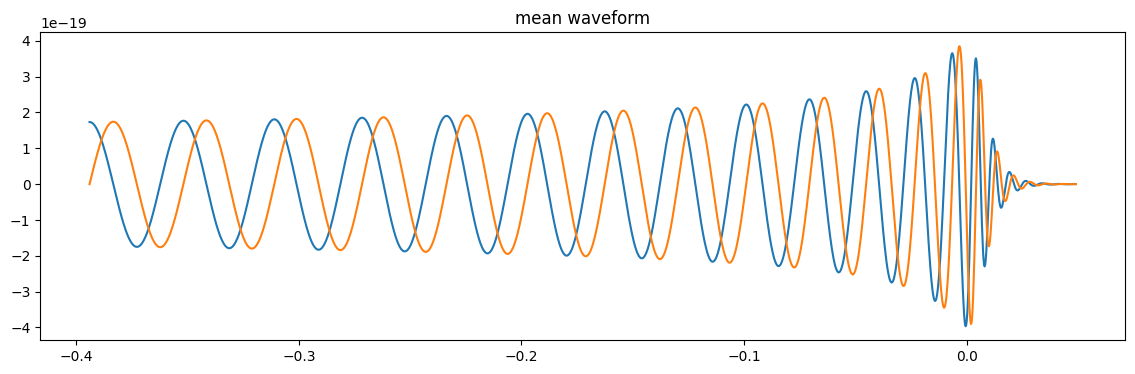

In [156]:
plt.figure(figsize=(14,4))
plt.plot(hp_ppm_bar[0].sample_times, hp_ppm_bar[0])
plt.plot(hp_ppm_bar[0].sample_times, hc_ppm_bar[0])
plt.title("mean waveform")

Text(0.5, 0, 'time [s]')

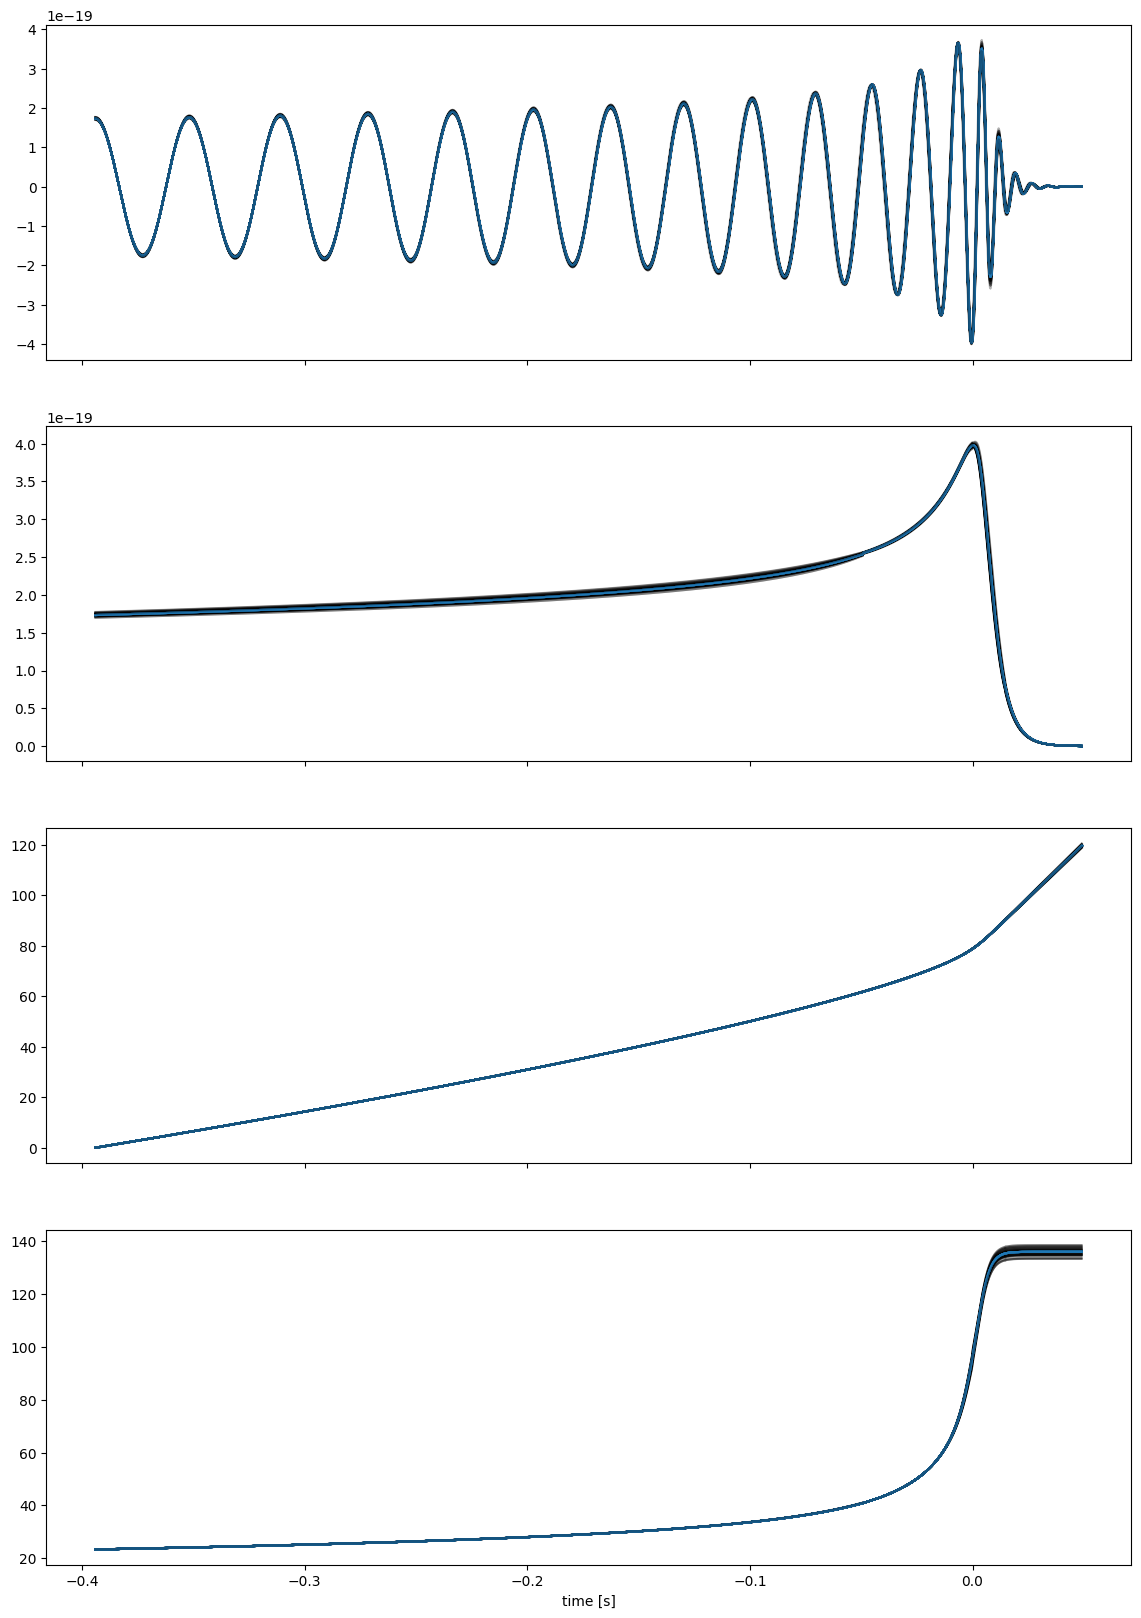

In [157]:
# this plot shows
# panel 1: h_plus
# panel 2: amplitude
# panel 3: phase
# panel 4: frequency

# blue: mean prediction from the model
# black lines: samples from the model

fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)
for hp, hc in zip(hp_ppm_samples, hc_ppm_samples):
    # mean
    axes[0].plot(hp_ppm_bar[0].sample_times, hp_ppm_bar[0], c='C0')
    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp_ppm_bar[0], hc_ppm_bar[0])
    axes[1].plot(amp.sample_times, amp, c='C0')

    phase = pycbc.waveform.utils.phase_from_polarizations(hp_ppm_bar[0], hc_ppm_bar[0])
    axes[2].plot(phase.sample_times, phase, c='C0')
    
    freq = pycbc.waveform.utils.frequency_from_polarizations(hp_ppm_bar[0], hc_ppm_bar[0])
    axes[3].plot(freq.sample_times, freq, c='C0')

    # samples
    axes[0].plot(hp.sample_times, hp, c='k', alpha=0.3)

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc)
    axes[1].plot(amp.sample_times, amp, c='k', alpha=0.3)

    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc)
    axes[2].plot(phase.sample_times, phase, c='k', alpha=0.3)

    freq = pycbc.waveform.utils.frequency_from_polarizations(hp, hc)
    axes[3].plot(freq.sample_times, freq, c='k', alpha=0.3)

# axes[0].set_xlim(-0.05, 0.1)

axes[3].set_xlabel('time [s]')

Text(0, 0.5, '$\\Delta \\phi$ [rad]')

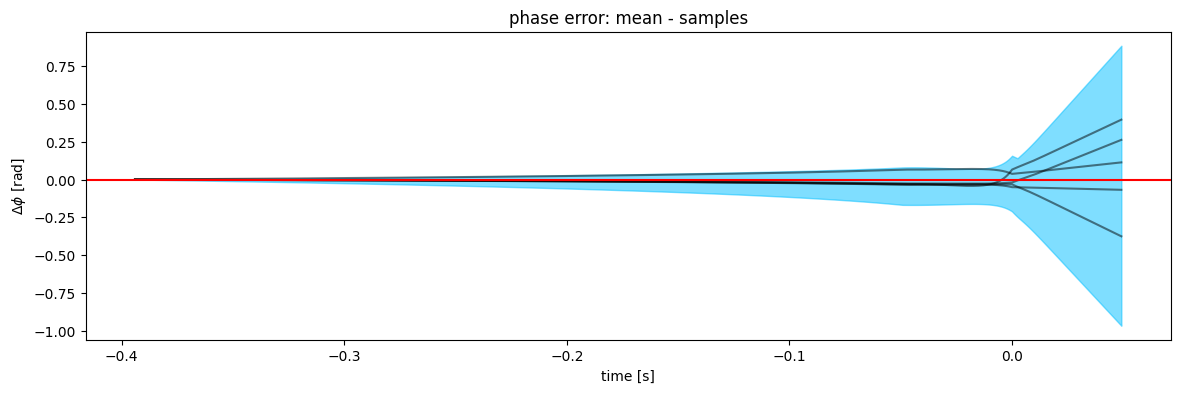

In [158]:
phase_mean = pycbc.waveform.utils.phase_from_polarizations(hp_ppm_bar[0], hc_ppm_bar[0])
phase_sample = np.array([pycbc.waveform.utils.phase_from_polarizations(hp, hc).numpy() for hp, hc in zip(hp_ppm_samples, hc_ppm_samples)])
phase_error = phase_mean.numpy()[:,np.newaxis] - phase_sample.T

plt.figure(figsize=(14, 4))
plt.plot(phase_mean.sample_times, phase_error[:,:5], c='k', alpha=0.5)
plt.fill_between(phase_mean.sample_times, y1=phase_error.min(1), y2=phase_error.max(1), alpha=0.5, color='deepskyblue')
plt.axhline(0, c='r')
plt.title("phase error: mean - samples")
plt.xlabel('time [s]')
plt.ylabel(r'$\Delta \phi$ [rad]')